In [99]:
import tqdm
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from dateutil import parser
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold

np.random.seed(4242)

In [2]:
%time df = pd.read_csv('dataset/dataset_no_2018.csv', encoding='cp1251', parse_dates=['date'])
df.drop('Unnamed: 0', axis=1, inplace=True)
stops = pd.read_csv('dataset/stops.csv', parse_dates=['date'])
df.shape, stops.shape

CPU times: user 37.9 s, sys: 2.06 s, total: 39.9 s
Wall time: 40.6 s


((3153599, 44), (47, 2))

In [3]:
columns_in = [
    'H2.C3..КОНТР.СООТН...212AIC008.PV', 
    'RF.21304.Ток...213MII904A',
    'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA',
    'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB',
    'SPEED.CONTROLLER...250MSIC001.PV',
    'НАГНЕТАНИЕ.В.EX.21401...250PI001',
    'ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A',
    'ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A',
    'РАСХОД.В....EX.21401...250FIC001.PV',
    'РАСХОД.ЛИНИИ.P.W...214FI205A',
    'ТОК.ДВИГ.ГРАНУЛЯТ...214II217A',
    'УПРАВЛЕНИЕ..P.25001A...250HIC001A',
    'ФАКТ.РАСХОД.ПРОП...213FY070',
    'ЭКСТР.ДВИГ.ПОТОК...214II200A'
]


df[columns_in] = (df[columns_in] - df[columns_in].min(axis=0)) / (df[columns_in].max(axis=0) - df[columns_in].min(axis=0))
calm = ((df[columns_in].diff() > 0.05).sum(axis=1) == 0).astype(int)

In [4]:
M_NEW_DATE_SPAN = 20
M_PRED_BEFORE_SPAN = 5
M_TOP_BOUND_SPAN = 10

new_dates = []
for stop_dt in stops.date[:-1]:
    new_dates.append(stop_dt - timedelta(minutes=M_NEW_DATE_SPAN))
    new_dates.append(stop_dt - timedelta(minutes=2 * M_NEW_DATE_SPAN))
    new_dates.append(stop_dt - timedelta(minutes=3 * M_NEW_DATE_SPAN))
    
new_stops = pd.DataFrame([[dt, 'stop'] for dt in new_dates], columns=stops.columns)
stops = pd.concat([stops.iloc[:-1], new_stops], axis=0)
stops.shape

(184, 2)

In [5]:
df_no_stops = df.copy()
for stop_dt in tqdm.tqdm(stops.date):
    date_range = (df_no_stops.date >= (stop_dt - timedelta(minutes=4 * M_NEW_DATE_SPAN))) \
        & (df_no_stops.date <= (stop_dt + timedelta(minutes=3 * M_NEW_DATE_SPAN)))
    df_no_stops = df_no_stops[~date_range]

df_no_stops.shape

100%|██████████| 184/184 [02:13<00:00,  1.38it/s]


(3099681, 44)

In [7]:
def make_features(df, periods=[1, 3, 10, 30, 50]):  # < M_TOP_BOUND_SPAN = 10 min
    columns = df.columns[df.columns != 'date']
    names = []
    vecs = []
    for period in periods:
        feats = [
            ('mean', df[-period:][columns].mean(axis=0).values),
            ('min', df[-period:][columns].min(axis=0).values),
            ('std', df[-period:][columns].std(axis=0).values),
            ('razd', df[-period - 1:][columns].diff().mean(axis=0).values)
        ]
        
        fs = []
        for f_name, f in feats:
            names.extend(f'{f_name}_{c}_{period}' for c in columns)
            fs.append(f)
        
        vecs.append(np.hstack(fs))
    
    return names, np.hstack(vecs)


NAMES = make_features(df)[0]

In [8]:
def make_range(df, stop_dt):
    return (df['date'] >= (stop_dt - timedelta(minutes=M_TOP_BOUND_SPAN))) & (df['date'] < stop_dt)


def make_false(df_no_stops, n_samples):
    random_work = np.random.choice(df_no_stops.shape[0], n_samples)
    xs = []
    ys = []
    for work in tqdm.tqdm(random_work):
        rng = df_no_stops[make_range(df_no_stops, df_no_stops.iloc[work]['date'] - timedelta(minutes=M_PRED_BEFORE_SPAN))]
        feature_vector = make_features(rng)[1]
        xs.append(feature_vector)
        ys.append(0)
    
    return np.array(xs), np.array(ys)

X_false, y_false = make_false(df_no_stops, 2000)
X_false.shape, y_false.shape

100%|██████████| 2000/2000 [01:18<00:00, 25.44it/s]


((2000, 860), (2000,))

In [9]:
def make_true(df_with_stops, stops):
    xs = []
    ys = []
    for stop_dt in tqdm.tqdm(stops.date):
        rng = df_with_stops[make_range(df_with_stops, stop_dt - timedelta(minutes=M_PRED_BEFORE_SPAN))]
        feature_vector = make_features(rng)[1]
        xs.append(feature_vector)
        ys.append(1)
    
    return np.array(xs), np.array(ys)

X_true, y_true = make_true(df, stops)
X_false.shape, X_true.shape

100%|██████████| 184/184 [00:07<00:00, 25.28it/s]


((2000, 860), (184, 860))

In [121]:
X = np.vstack([X_false, X_true])
y = np.hstack([y_false, y_true]).T
X.shape, y.shape

((2184, 860), (2184,))

# Linear

In [105]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score


model = SGDClassifier(tol=1e-3)
X_train, X_val, y_train, y_val = train_test_split(np.nan_to_num(X), y, test_size=0.2)
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [107]:
accuracy_score(y_val, model.predict(X_val))

0.919908466819222

In [108]:
f1_score(y_val, model.predict(X_val))

/Users/rebryk/Projects/sibur-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

# LGBM

In [11]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling120(X, y):
    X, y = pd.DataFrame(X), pd.Series(y)
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = len(ids0)
    sampled_ids1 = y[y == 1].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids1]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids0]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids1].as_matrix(), index=index), y[ids0]], axis=0)
    assert (nX.index == ny.index).all()
    return nX.as_matrix(), ny.as_matrix()


def good_upsampling(X, y):
    X_false, X_true = X[y == 0], X[y == 1]
    y_false, y_true = y[y == 0], y[y == 1]
    ids = pd.Series(np.arange(len(X_true))).sample(len(X_false), replace=True).index
    X = np.vstack([X_false, X_true[ids]])
    y = np.hstack([y_false, y_true[ids]]).T
    return X, y

In [59]:
def make_train_val(X, y, n_folds):
    if n_folds == 1:
        return (train_test_split(X, y),)
    else:
        skf = StratifiedKFold(n_splits=n_folds, random_state=0)
        return ((X[train_index], X[test_index], y[train_index], y[test_index]) 
                for train_index, test_index in skf.split(X, y))

In [79]:
test_size = 0.0
n_splits = 1
n_folds = 3
max_rounds = 10000
params = {
    'num_leaves': 2 ** 5 - 1,
    'objective': 'binary',
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'learning_rate': 1e-3,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'binary',
    'num_threads': 4,
#         'is_unbalanced': True
    'scale_pos_weight': 4
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
if n_splits == 1:
    inds = [np.arange(len(X_train))]
else:
    X_train, y_train = pd.DataFrame(X_train), pd.Series(y_train)
    X_false, X_true = X_train[y_train == 0], X_train[y_train == 1]
    y_false, y_true = y_train[y_train == 0], y_train[y_train == 1]
    
    inds = np.arange(len(X_false))
    np.random.shuffle(inds)
    inds = np.array_split(inds, n_splits)
    inds = [np.hstack([
        X_false.iloc[i_ind].index.values, 
        X_true.index.values
    ]) for i_ind in inds]
    
    X_train, y_train = X_train.as_matrix(), y_train.as_matrix()
    
X_vals = []
y_vals = []
models = []
    
predicted = []
f_scores = []
for i, train_index in enumerate(inds):
    X_train1, y_train1 = X_train[train_index], y_train[train_index]
    
    i_f_scores = []
    for X_train2, X_val, y_train2, y_val in make_train_val(X_train1, y_train1, n_folds):
        X_train2, y_train2 = good_upsampling(X_train2, y_train2)
        
        dtrain = lgb.Dataset(
            X_train2, label=y_train2,
            categorical_feature=[]
        )

        dval = lgb.Dataset(
            X_val, label=y_val, reference=dtrain,
            categorical_feature=[]
        )

        bst = lgb.train(
            params, dtrain, num_boost_round=max_rounds,
            valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=50
        )
        
        
        X_vals.append(X_val)
        y_vals.append(y_val)
        models.append(bst)
        
        y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.5).astype(int)
        i_f_scores.append(f1_score (y_val, y_pred))
        predicted.append(bst.predict(X_test, num_iteration=bst.best_iteration or max_rounds))
    
    print(i_f_scores)
    f_scores.append(np.mean(i_f_scores))

# Metrics
model = bst
print('---------------------')
print(f'f_scores: {f_scores}')
if test_size > 0:
    y_pred = (np.mean(predicted, axis=0) > 0.5).astype(int)
    print(f'test f1 score: {fbeta_score(y_test, y_pred)}')

/Users/rebryk/Projects/sibur-env/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[50]	training's binary_logloss: 0.664733	valid_1's binary_logloss: 0.676701
[100]	training's binary_logloss: 0.63919	valid_1's binary_logloss: 0.662641
[150]	training's binary_logloss: 0.615507	valid_1's binary_logloss: 0.649661
[200]	training's binary_logloss: 0.593651	valid_1's binary_logloss: 0.637874
[250]	training's binary_logloss: 0.573519	valid_1's binary_logloss: 0.627319
[300]	training's binary_logloss: 0.55484	valid_1's binary_logloss: 0.617717
[350]	training's binary_logloss: 0.537667	valid_1's binary_logloss: 0.609375
[400]	training's binary_logloss: 0.52161	valid_1's binary_logloss: 0.601661
[450]	training's binary_logloss: 0.506378	valid_1's binary_logloss: 0.594241
[500]	training's binary_logloss: 0.4923	valid_1's binary_logloss: 0.587499
[550]	training's binary_logloss: 0.479617	valid_1's binary_logloss: 0.582205
[600]	training's binary_logloss: 0.467801	valid_1's binary_logloss: 0.577483
[650]	training's bi

[5300]	training's binary_logloss: 0.0606944	valid_1's binary_logloss: 0.234135
[5350]	training's binary_logloss: 0.0593568	valid_1's binary_logloss: 0.232631
[5400]	training's binary_logloss: 0.057945	valid_1's binary_logloss: 0.231067
[5450]	training's binary_logloss: 0.0567152	valid_1's binary_logloss: 0.229581
[5500]	training's binary_logloss: 0.0555161	valid_1's binary_logloss: 0.228132
[5550]	training's binary_logloss: 0.0542821	valid_1's binary_logloss: 0.226585
[5600]	training's binary_logloss: 0.0530806	valid_1's binary_logloss: 0.225207
[5650]	training's binary_logloss: 0.0519499	valid_1's binary_logloss: 0.223811
[5700]	training's binary_logloss: 0.0508543	valid_1's binary_logloss: 0.222505
[5750]	training's binary_logloss: 0.0497056	valid_1's binary_logloss: 0.221208
[5800]	training's binary_logloss: 0.0486185	valid_1's binary_logloss: 0.219976
[5850]	training's binary_logloss: 0.0475448	valid_1's binary_logloss: 0.21865
[5900]	training's binary_logloss: 0.0465765	valid_1's 

[400]	training's binary_logloss: 0.541437	valid_1's binary_logloss: 0.621503
[450]	training's binary_logloss: 0.526938	valid_1's binary_logloss: 0.613905
[500]	training's binary_logloss: 0.514224	valid_1's binary_logloss: 0.608103
[550]	training's binary_logloss: 0.501868	valid_1's binary_logloss: 0.601878
[600]	training's binary_logloss: 0.489946	valid_1's binary_logloss: 0.595603
[650]	training's binary_logloss: 0.479237	valid_1's binary_logloss: 0.590464
[700]	training's binary_logloss: 0.468152	valid_1's binary_logloss: 0.584163
[750]	training's binary_logloss: 0.457691	valid_1's binary_logloss: 0.578285
[800]	training's binary_logloss: 0.448475	valid_1's binary_logloss: 0.573674
[850]	training's binary_logloss: 0.439011	valid_1's binary_logloss: 0.568123
[900]	training's binary_logloss: 0.429972	valid_1's binary_logloss: 0.563031
[950]	training's binary_logloss: 0.421479	valid_1's binary_logloss: 0.558038
[1000]	training's binary_logloss: 0.413134	valid_1's binary_logloss: 0.55296

[5700]	training's binary_logloss: 0.0579258	valid_1's binary_logloss: 0.200115
[5750]	training's binary_logloss: 0.0566669	valid_1's binary_logloss: 0.198765
[5800]	training's binary_logloss: 0.0554698	valid_1's binary_logloss: 0.197416
[5850]	training's binary_logloss: 0.0544011	valid_1's binary_logloss: 0.196192
[5900]	training's binary_logloss: 0.0533159	valid_1's binary_logloss: 0.194997
[5950]	training's binary_logloss: 0.0521921	valid_1's binary_logloss: 0.193723
[6000]	training's binary_logloss: 0.0511008	valid_1's binary_logloss: 0.192515
[6050]	training's binary_logloss: 0.0500186	valid_1's binary_logloss: 0.191289
[6100]	training's binary_logloss: 0.0489652	valid_1's binary_logloss: 0.190134
[6150]	training's binary_logloss: 0.0480299	valid_1's binary_logloss: 0.189023
[6200]	training's binary_logloss: 0.0470324	valid_1's binary_logloss: 0.187875
[6250]	training's binary_logloss: 0.0460556	valid_1's binary_logloss: 0.186697
[6300]	training's binary_logloss: 0.0450916	valid_1'

[800]	training's binary_logloss: 0.427874	valid_1's binary_logloss: 0.550459
[850]	training's binary_logloss: 0.418189	valid_1's binary_logloss: 0.545099
[900]	training's binary_logloss: 0.408927	valid_1's binary_logloss: 0.539853
[950]	training's binary_logloss: 0.399918	valid_1's binary_logloss: 0.534587
[1000]	training's binary_logloss: 0.391629	valid_1's binary_logloss: 0.529992
[1050]	training's binary_logloss: 0.383554	valid_1's binary_logloss: 0.525319
[1100]	training's binary_logloss: 0.375261	valid_1's binary_logloss: 0.519975
[1150]	training's binary_logloss: 0.367453	valid_1's binary_logloss: 0.515055
[1200]	training's binary_logloss: 0.359528	valid_1's binary_logloss: 0.509619
[1250]	training's binary_logloss: 0.352059	valid_1's binary_logloss: 0.504584
[1300]	training's binary_logloss: 0.344527	valid_1's binary_logloss: 0.499218
[1350]	training's binary_logloss: 0.336848	valid_1's binary_logloss: 0.493278
[1400]	training's binary_logloss: 0.329667	valid_1's binary_logloss:

[6050]	training's binary_logloss: 0.0551101	valid_1's binary_logloss: 0.228909
[6100]	training's binary_logloss: 0.0541387	valid_1's binary_logloss: 0.227997
[6150]	training's binary_logloss: 0.0530761	valid_1's binary_logloss: 0.22687
[6200]	training's binary_logloss: 0.052086	valid_1's binary_logloss: 0.225842
[6250]	training's binary_logloss: 0.0511008	valid_1's binary_logloss: 0.224776
[6300]	training's binary_logloss: 0.0500696	valid_1's binary_logloss: 0.223706
[6350]	training's binary_logloss: 0.0490819	valid_1's binary_logloss: 0.222628
[6400]	training's binary_logloss: 0.0481423	valid_1's binary_logloss: 0.221727
[6450]	training's binary_logloss: 0.0472316	valid_1's binary_logloss: 0.220917
[6500]	training's binary_logloss: 0.0463074	valid_1's binary_logloss: 0.22
[6550]	training's binary_logloss: 0.0455145	valid_1's binary_logloss: 0.219206
[6600]	training's binary_logloss: 0.0446277	valid_1's binary_logloss: 0.218348
[6650]	training's binary_logloss: 0.0438266	valid_1's bina

In [93]:
np.mean([fbeta_score(y_val, (model.predict(X_val) >= 0.2).astype(int), 2) for X_val, y_val, model in zip(X_vals, y_vals, models)])

0.7029649021936364

In [94]:
np.mean([(model.predict(X_val) >= 0.2).astype(int)[y_val == 1].mean() for X_val, y_val, model in zip(X_vals, y_vals, models)])

0.782742816851754

In [95]:
np.mean([(model.predict(X_val) >= 0.2).astype(int)[y_val == 0].mean() for X_val, y_val, model in zip(X_vals, y_vals, models)])

0.07200078639358999

In [ ]:
test_size = 0.0
n_splits = 1
n_folds = 1
max_rounds = 10000
params = {
    'num_leaves': 2 ** 5 - 1,
    'objective': 'binary',
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'learning_rate': 1e-3,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'binary',
    'num_threads': 4,
#         'is_unbalanced': True
    'scale_pos_weight': 4
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
if n_splits == 1:
    inds = [np.arange(len(X_train))]
else:
    X_train, y_train = pd.DataFrame(X_train), pd.Series(y_train)
    X_false, X_true = X_train[y_train == 0], X_train[y_train == 1]
    y_false, y_true = y_train[y_train == 0], y_train[y_train == 1]
    
    inds = np.arange(len(X_false))
    np.random.shuffle(inds)
    inds = np.array_split(inds, n_splits)
    inds = [np.hstack([
        X_false.iloc[i_ind].index.values, 
        X_true.index.values
    ]) for i_ind in inds]
    
    X_train, y_train = X_train.as_matrix(), y_train.as_matrix()

predicted = []
f_scores = []

for i, train_index in enumerate(inds):
    X_train1, y_train1 = X_train[train_index], y_train[train_index]
    
    i_f_scores = []
    for X_train2, X_val, y_train2, y_val in make_train_val(X_train1, y_train1, n_folds):
        X_train2, y_train2 = good_upsampling(X_train2, y_train2)

        dtrain = lgb.Dataset(
            X_train2, label=y_train2,
            categorical_feature=[]
        )

        dval = lgb.Dataset(
            X_val, label=y_val, reference=dtrain,
            categorical_feature=[]
        )

        bst = lgb.train(
            params, dtrain, num_boost_round=max_rounds,
            valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=50
        )
        
        y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.5).astype(int)
        i_f_scores.append(f1_score(y_val, y_pred))
        predicted.append(bst.predict(X_test, num_iteration=bst.best_iteration or max_rounds))
    
    print(i_f_scores)
    f_scores.append(np.mean(i_f_scores))

# Metrics
model = bst
print('---------------------')
print(f'f_scores: {f_scores}')
if test_size > 0:
    y_pred = (np.mean(predicted, axis=0) > 0.5).astype(int)
    print(f'test f1 score: {fbeta_score(y_test, y_pred)}')

In [134]:
model = models[0]
X_train2, X_val, y_train2, y_val = list(make_train_val(X_train1, y_train1, n_folds))[0]
y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.2).astype(int)
auc1 = roc_auc_score(y_val, y_pred)

In [135]:
model = models[1]
X_train2, X_val, y_train2, y_val = list(make_train_val(X_train1, y_train1, n_folds))[1]
y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.2).astype(int)
auc2 = roc_auc_score(y_val, y_pred)

In [136]:
model = models[2]
X_train2, X_val, y_train2, y_val = list(make_train_val(X_train1, y_train1, n_folds))[2]
y_pred = (bst.predict(X_val, num_iteration=bst.best_iteration or max_rounds)> 0.2).astype(int)
auc3 = roc_auc_score(y_val, y_pred)

In [137]:
auc = np.array([auc1, auc2, auc3])

In [139]:
auc.mean()

0.9440055054932043

# Predict

In [19]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]

    objects = pd.Series(columns)[order]
    y_pos = np.arange(len(objects))
    performance = importances[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)

    plt.show()

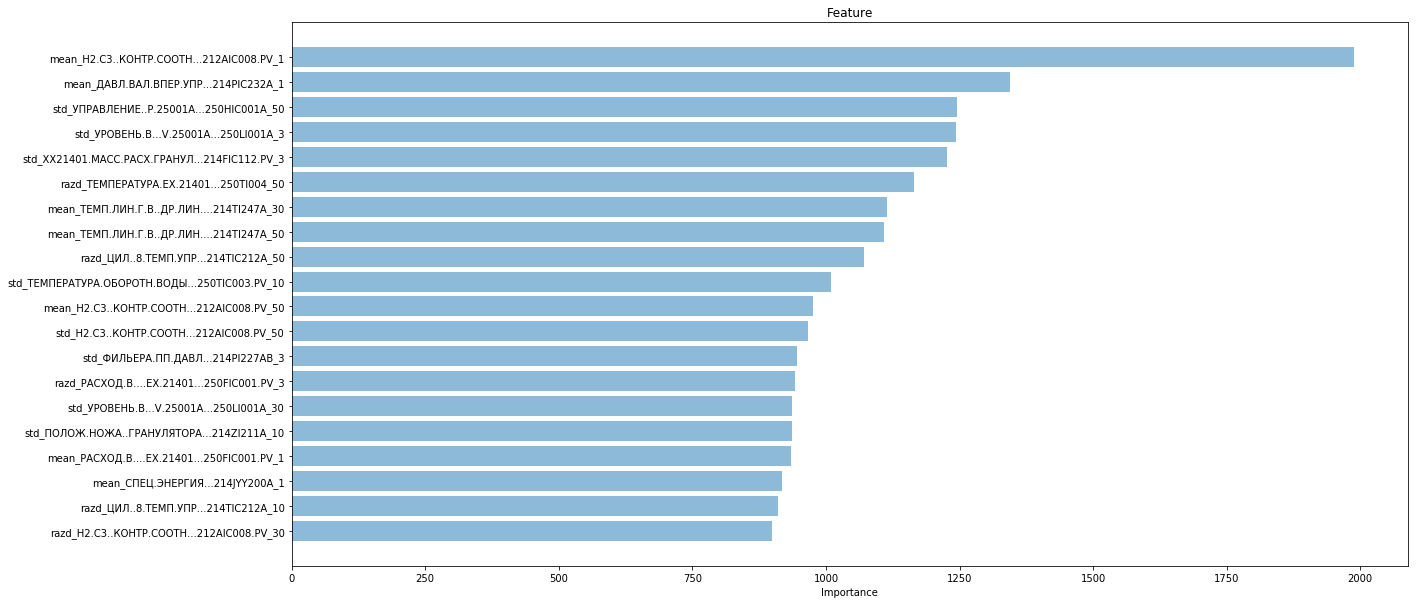

In [20]:
draw_importance(NAMES, model.feature_importance(), top_k=20)

In [21]:
def get_topk_features(x, x_mean, k=5):
    p = model.predict(np.array([x]))[0]
    imp = []
    for feature_id in np.argsort(model.feature_importance())[-100:]:
        xc = x.copy()
        xc[feature_id] = x_mean[feature_id]
        p1 = model.predict(np.array([xc]))[0]
        imp.append((p - p1, NAMES[feature_id], feature_id))
    
    return p, sorted(imp, reverse=True)[:5]


# get_topk_features(make_features(df)[1])

In [22]:
def get_by_date(date, csv_path):
    """
    :param date: timedate in hours
    """
    
    date_range = (df.date >= date) & (df.date < (date + timedelta(minutes=240)))
    dates = list(df[date_range].date)
    xvalues = []
    rvalues = []
    k = 5
    
    xs = []
    for dt in tqdm.tqdm(dates):
        x = make_features(df[make_range(df, dt - timedelta(minutes=M_PRED_BEFORE_SPAN))])[1]
        xs.append(x)
    x_mean = np.mean(xs, axis=0)
    
    ps = []
    ass = []
    for dt, x in zip(tqdm.tqdm(dates), xs):
        fs = []
        p, features = get_topk_features(x, x_mean, k=k)
        ps.append(p)
        for a, _, f_i in features:
            fs.append(f_i)
        
        xvalues.append(x)
        rvalues.append(fs)
        
    ddf = pd.DataFrame(
        dates,
        index=list(range(len(dates))),
        columns=['date']
    )
    
    xdf = pd.DataFrame(
        xvalues
    )
    xdf = pd.concat([ddf, xdf], axis=1)
    xdf.to_csv('xxx' + csv_path, index=None)
    
    rdf = pd.DataFrame(
        rvalues,
        columns=[f'top{i}_feature' for i in range(1, k + 1)]
    )
    rdf = pd.concat([ddf, rdf], axis=1)
    rdf.to_csv(csv_path, index=None)
    
    pdf = pd.DataFrame(
        ps,
        columns=['prob']
    )
    
    pdf.to_csv('ppp' + csv_path, index=None)
    
    return ps

In [23]:
stops.iloc[:20]

,date,type
0,2017-11-01 11:03:00,stop
1,2017-01-30 08:51:00,stop
2,2017-02-24 17:45:00,stop
3,2017-07-03 00:16:00,stop
4,2017-08-03 11:23:00,vibrosito
5,2017-08-03 15:56:00,vibrosito
6,2017-10-03 17:55:00,stop
7,2017-03-31 01:42:00,vibrosito
8,2017-01-04 07:45:00,stop
9,2017-03-04 20:48:00,stop


In [24]:
# date, csv_path = parser.parse('2017-11-01 09:10'), 'sasha.csv'
date, csv_path = parser.parse('2017-06-10 01:00'), 'sasha.csv'
date

datetime.datetime(2017, 6, 10, 1, 0)

In [25]:
p = get_by_date(date, csv_path)
p[:4]

100%|██████████| 1440/1440 [03:20<00:00,  7.19it/s]


[0.5013974176651529,
 0.3497626257018101,
 0.09650198093735121,
 0.4364884041865759]

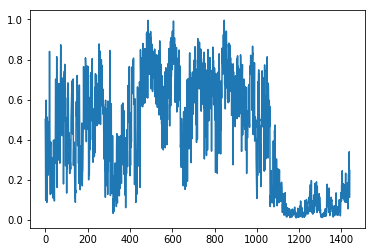

In [26]:
plt.plot(p)

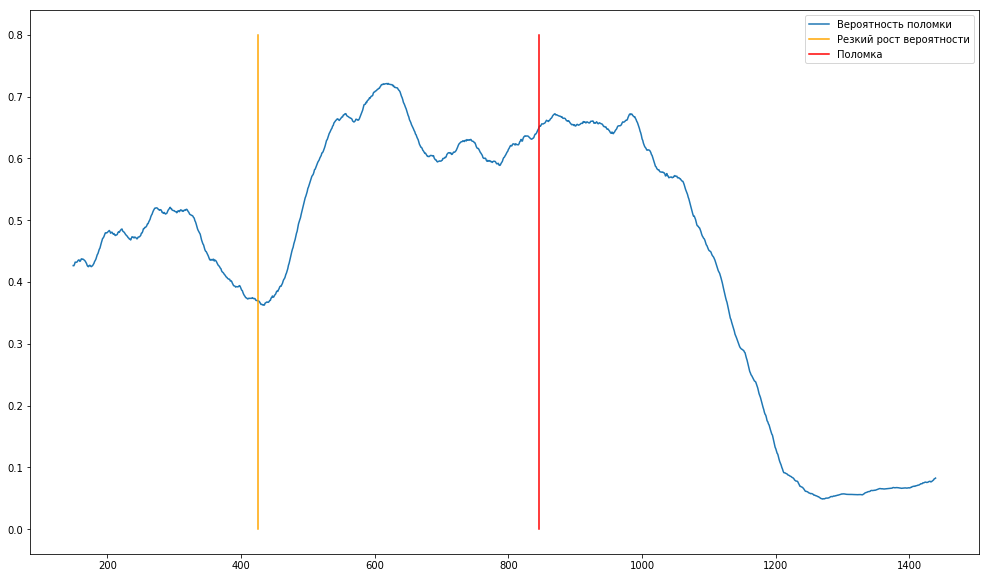

In [27]:
plt.figure(figsize=(17, 10))
pd.Series(p).rolling(150).mean().plot(label='Вероятность поломки');
plt.plot([426, 426], [0, 0.8], color='orange', label='Резкий рост вероятности');
plt.plot([846, 846], [0, 0.8], color='r', label='Поломка');
plt.legend()
plt.savefig('ptimeplot1.png');